In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import glob
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from alexnet import AlexNet
from lenet5 import LeNet5
from data_loading import DataLoaderCreator
import re


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def load_results(csv_path):
    return pd.read_csv(csv_path)

In [4]:
def load_model(model, model_path, dropout_rate=0, init_type='random'):
    if model == 'alexnet':
        model = AlexNet(dropout_rate=dropout_rate, init_type=init_type)
    elif model == 'lenet5':
        model = LeNet5(dropout_rate=dropout_rate, init_type=init_type)
    else:
        raise ValueError("Invalid model name")
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # CPU/GPU
    model.eval()
    return model

In [5]:
def evaluate_model(model, test_loader, device):
    model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy

In [8]:
model_paths = glob.glob("saved_models/lenet5_constant_lr_0.01_seed_*.pth")
accuracies = []

loader_creator = DataLoaderCreator(seed=123)
test_loader = loader_creator.create_data_loader('cinic-10/test', batch_size=128)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for model_path in model_paths:
    print(f"Evaluating {model_path}...")
    model = load_model("lenet5", model_path, dropout_rate=0, init_type='random')
    accuracy = evaluate_model(model, test_loader, device)
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy:.2f}%")

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies, ddof=1)

print(f"\nMean accuracy: {mean_accuracy:.2f}%")
print(f"Standard Deviation: {std_accuracy:.2f}%")

Evaluating saved_models\lenet5_constant_lr_0.01_seed_123.pth...
Accuracy: 32.11%
Evaluating saved_models\lenet5_constant_lr_0.01_seed_33.pth...
Accuracy: 26.73%

Mean accuracy: 29.42%
Standard Deviation: 3.80%


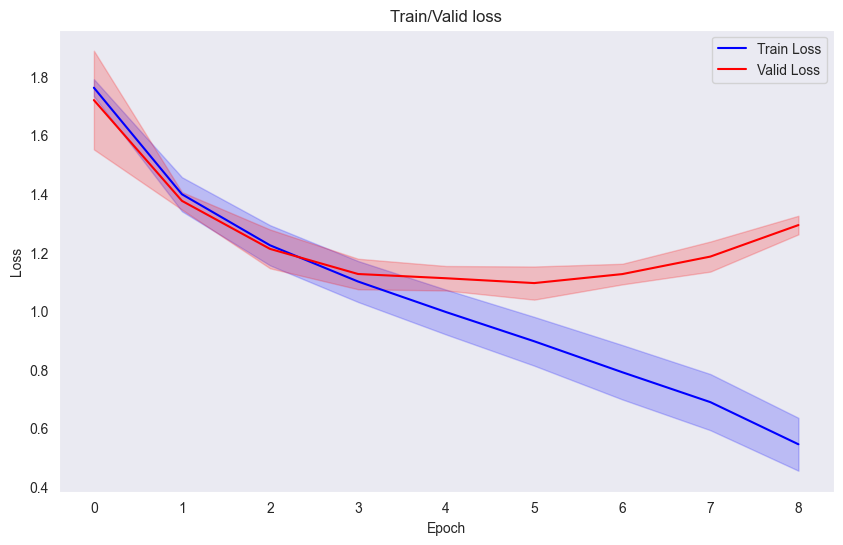

In [18]:
csv_files = glob.glob("saved_losses/alexnet_constant_lr_0.001_seed_*.csv")

all_data = []

for file in csv_files:
    match = re.search(r"seed_(\d+)", file)
    seed = int(match.group(1))
    df = pd.read_csv(file, names=["train_loss", "valid_loss"], header=0)
    df["epoch"] = df.index
    df["seed"] = seed
    all_data.append(df)


df_all = pd.concat(all_data)

df_grouped = df_all.groupby("epoch").agg(
    train_loss_mean=("train_loss", "mean"),
    train_loss_std=("train_loss", "std"),
    valid_loss_mean=("valid_loss", "mean"),
    valid_loss_std=("valid_loss", "std")
).reset_index()

plt.figure(figsize=(10, 6))

plt.plot(df_grouped["epoch"], df_grouped["train_loss_mean"], label="Train Loss", color="blue")
plt.fill_between(df_grouped["epoch"],
                 df_grouped["train_loss_mean"] - df_grouped["train_loss_std"],
                 df_grouped["train_loss_mean"] + df_grouped["train_loss_std"],
                 color="blue", alpha=0.2)

plt.plot(df_grouped["epoch"], df_grouped["valid_loss_mean"], label="Valid Loss", color="red")
plt.fill_between(df_grouped["epoch"],
                 df_grouped["valid_loss_mean"] - df_grouped["valid_loss_std"],
                 df_grouped["valid_loss_mean"] + df_grouped["valid_loss_std"],
                 color="red", alpha=0.2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Valid loss")
plt.legend()
plt.grid()
plt.show()
